In [198]:
# 기본 라이브러리 로드
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 관련
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [199]:
# 2. 데이터 불러오기
customers = pd.read_csv("./data/archive/datathon/dataset_customer.csv")
orders = pd.read_csv("./data/archive/datathon/dataset_orders.csv")

In [200]:
# 주문 수 컬럼 이름 변경
customers = customers.rename(columns={'order_id': 'order_count'})

In [201]:
customers.head()

,customer_id,order_count,payment_value,order_spent
0,00012a2ce6f8dcda20d059ce98491703,1,114.74,114.74
1,000161a058600d5901f007fab4c27140,1,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,1,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,1,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,1,107.01,107.01


In [202]:
customers.isnull().sum()

customer_id      0
order_count      0
payment_value    0
order_spent      0
dtype: int64

In [203]:
orders.head()

,customer_id,region,order_id,order_status,payment_type,payment_installments,payment_value,review_score,date,timestamp,product_category_name,product_category_name_english,main_category
0,06b8999e2fba1a1fbc88172c00ba8bc7,남동부,00e7ee1b050b8499577073aeb2a297a1,0,1,2.0,146.87,4.0,"['2017', '05']",오후,moveis_escritorio,office_furniture,가구/집
1,18955e83d337fd6b2def6b18a428ac77,남동부,29150127e6685892b6eab3eec79f59c7,0,1,8.0,335.48,5.0,"['2018', '01']",저녁,utilidades_domesticas,housewares,가구/집
2,4e7b3e00288586ebd08712fdd0374a03,남동부,b2059ed67ce144a36e2aa97d2c9e9ad2,0,1,7.0,157.73,5.0,"['2018', '05']",오후,moveis_escritorio,office_furniture,가구/집
3,b2b6027bc5c5109e529d4dc6358b12c3,남동부,951670f92359f4fe4a63112aa7306eba,0,1,1.0,173.30,5.0,"['2018', '03']",오후,moveis_escritorio,office_furniture,가구/집
4,4f2d8ab171c80ec8364f7c12e35b23ad,남동부,6b7d50bd145f6fc7f33cebabd7e49d0f,0,1,8.0,252.25,5.0,"['2018', '07']",오전,casa_conforto,home_confort,가구/집


In [204]:
main_category_nan = orders[orders['main_category'].isna()]

In [205]:
main_category_nan.head(50)

,customer_id,region,order_id,order_status,payment_type,payment_installments,payment_value,review_score,date,timestamp,product_category_name,product_category_name_english,main_category


In [206]:
orders.isnull().sum()

customer_id                         0
region                              0
order_id                            0
order_status                        0
payment_type                        0
payment_installments                0
payment_value                       0
review_score                        0
date                                0
timestamp                           0
product_category_name            3303
product_category_name_english    3330
main_category                       0
dtype: int64

In [207]:
merged_df['timestamp'].unique()

array(['오후', '오전', '저녁', '새벽'], dtype=object)

In [208]:
print(merged_df['timestamp'].value_counts())

timestamp
오후    55117
저녁    48498
오전    29843
새벽     6985
Name: count, dtype: int64


In [209]:
# 병합 및 평균지출금액 계산
merged_df = pd.merge(customers, orders, on="customer_id", how="inner")
merged_df["avg_spent_per_order"] = merged_df["order_spent"] / merged_df["order_count"]

In [210]:
# 사용자 정의 카테고리 분류 맵
category_map = {
    '식품/음료': '소비 생활용품군',
    '패션/잡화': '소비 생활용품군',
    '가구/집': '가구/집',
    '유아/어린이': '유아/어린이',
    '전자/IT': '전자/IT',
    '책/문화': '문화',
    '취미/여가': '문화',
}

# main_category 재분류
merged_df['category_group'] = merged_df['main_category'].map(category_map).fillna('기타')

In [211]:
# 인코딩 실행 (기존 merged_df에 컬럼 추가)
merged_encoded_df = pd.get_dummies(merged_df, columns=['timestamp', 'category_group'], drop_first=False)

# 원핫 컬럼들을 정수형 0/1로 변환
one_hot_cols = [col for col in merged_encoded_df.columns if col.startswith('timestamp_') or col.startswith('category_group_')]
merged_encoded_df[one_hot_cols] = merged_encoded_df[one_hot_cols].astype(int)

In [212]:
merged_encoded_df.head()

,customer_id,order_count,payment_value_x,order_spent,region,order_id,order_status,payment_type,payment_installments,payment_value_y,...,timestamp_새벽,timestamp_오전,timestamp_오후,timestamp_저녁,category_group_가구/집,category_group_기타,category_group_문화,category_group_소비 생활용품군,category_group_유아/어린이,category_group_전자/IT
0,00012a2ce6f8dcda20d059ce98491703,1,114.74,114.74,남동부,5f79b5b0931d63f1a42989eb65b9da6e,0,1,8.0,114.74,...,0,0,1,0,0,0,0,0,1,0
1,000161a058600d5901f007fab4c27140,1,67.41,67.41,남동부,a44895d095d7e0702b6a162fa2dbeced,0,1,5.0,67.41,...,0,1,0,0,0,0,0,1,0,0
2,0001fd6190edaaf884bcaf3d49edf079,1,195.42,195.42,남동부,316a104623542e4d75189bb372bc5f8d,0,1,10.0,195.42,...,0,1,0,0,0,0,0,0,1,0
3,0002414f95344307404f0ace7a26f1d5,1,179.35,179.35,남동부,5825ce2e88d5346438686b0bba99e5ee,0,0,1.0,179.35,...,0,0,1,0,0,0,1,0,0,0
4,000379cdec625522490c315e70c7a9fb,1,107.01,107.01,남동부,0ab7fb08086d4af9141453c91878ed7a,0,0,1.0,107.01,...,0,0,1,0,1,0,0,0,0,0


In [213]:
import pandas as pd

df = pd.DataFrame(merged_encoded_df)

# CSV로 저장
df.to_csv("merged_encoded_df.csv", index=False, encoding="utf-8-sig")

In [365]:
# 이상치 제거 파일 불러오기
merged_encoded_df = pd.read_csv("./data/archive/datathon/merged_df_이상치제거.csv")

In [366]:
# 컬럼 선택
excluded_columns = ['customer_id', 'region', 'order_id', 'date', 'timestamp', 
                    'product_category_name', 'product_category_name_english', 
                    'main_category', 'category_group']
features = [col for col in merged_encoded_df.columns if col not in excluded_columns]

In [367]:
# 모든 지역에 대해 k=3으로 설정 # 향후 elbow method 분석 결과를 바탕으로 실제 k값을 수동으로 교체하기 쉽게 만들어두기 위함
optimal_k_per_region = {region: 3 for region in merged_encoded_df['region'].unique()}

In [216]:
!pip install yellowbrick

In [250]:
merged_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140443 entries, 0 to 140442
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    140443 non-null  object 
 1   order_count                    140443 non-null  int64  
 2   payment_value_x                140443 non-null  float64
 3   order_spent                    140443 non-null  float64
 4   region                         140443 non-null  object 
 5   order_id                       140443 non-null  object 
 6   order_status                   140443 non-null  int64  
 7   payment_type                   140443 non-null  int64  
 8   payment_installments           140443 non-null  float64
 9   payment_value_y                140443 non-null  float64
 10  review_score                   140443 non-null  float64
 11  date                           140443 non-null  object 
 12  product_category_name         

In [380]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from yellowbrick.cluster import KElbowVisualizer

# 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)
mpl.rc('font', family=fontprop.get_name())
plt.rcParams['axes.unicode_minus'] = False

# 저장 폴더 설정
output_dir = "elbow_plots"
os.makedirs(output_dir, exist_ok=True)

regions = merged_encoded_df['region'].unique()
features = [
    'order_count',
    'order_spent',
    'timestamp_오전',
    'timestamp_오후',
    'timestamp_저녁',
    'timestamp_새벽'
]

for region in regions:
    print(f"📊 지역: {region}")
    region_df = merged_encoded_df[merged_encoded_df['region'] == region]
    X = region_df[features].dropna()

    if X.shape[0] < 5:
        print(f"⚠️ {region} 지역은 데이터 수가 부족하여 스킵합니다.\n")
        continue

    # 표준화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Elbow 시각화 및 저장
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, 10))
    visualizer.fit(X_scaled)
    visualizer.finalize()

    plt.savefig(f"{output_dir}/elbow_{region}.png", dpi=300)
    plt.close()

📊 지역: 남동부
📊 지역: 남부
📊 지역: 북동부
📊 지역: 중서부
📊 지역: 북부


In [381]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

# 사용할 피처 (전체 대상)
features = [
    'order_count',
    'order_spent',
    'timestamp_오전',
    'timestamp_오후',
    'timestamp_저녁',
    'timestamp_새벽'
]

# 결측 제거
X = merged_encoded_df[features].dropna()

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 모델 및 시각화 도구 설정
model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(1, 10), metric='distortion', timings=False)

# 학습 및 시각화
visualizer.fit(X_scaled)
visualizer.finalize()  # show() 대신 사용

# 이미지로 저장
plt.savefig("전체_엘보우_그래프.png", dpi=300)
plt.close()

In [382]:
# 클러스터
clustered_customers = []
for region in merged_encoded_df['region'].unique():
    region_df = merged_encoded_df[merged_encoded_df['region'] == region]
    X = region_df[features].dropna()
    
    if X.shape[0] < 5:
        continue
    index = X.index
    ids = merged_encoded_df.loc[index, ['customer_id', 'region', 'order_count',
    'order_spent',
    'timestamp_오전',
    'timestamp_오후',
    'timestamp_저녁',
    'timestamp_새벽']]


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    ids['cluster'] = labels
    clustered_customers.append(ids)

In [383]:
# 통합 클러스터 결과
final_cluster_df = pd.concat(clustered_customers, ignore_index=True)

In [384]:
final_cluster_df

,customer_id,region,order_count,order_spent,timestamp_오전,timestamp_오후,timestamp_저녁,timestamp_새벽,cluster
0,00012a2ce6f8dcda20d059ce98491703,남동부,1,114.74,0,1,0,0,1
1,0001fd6190edaaf884bcaf3d49edf079,남동부,1,195.42,1,0,0,0,2
2,0002414f95344307404f0ace7a26f1d5,남동부,1,179.35,0,1,0,0,1
3,000419c5494106c306a97b5635748086,남동부,1,49.40,0,1,0,0,1
4,00046a560d407e99b969756e0b10f282,남동부,1,166.59,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...
75190,ff361c0d307ae1d980189154e73fadc5,북부,1,182.85,0,0,1,0,2
75191,ff84a9059c97689052afa88a20cfc52b,북부,1,309.73,0,0,1,0,2
75192,ff8fa0e333a5b7b5362e76311b4ae90a,북부,1,66.69,0,0,1,0,2
75193,ffcf601742639fe15057352054f9e8fe,북부,1,97.09,0,0,1,0,2


In [385]:
# 군집별 평균 특성 통계
cluster_stats_by_region = final_cluster_df.groupby(['region', 'cluster'])[['order_count',
    'order_spent',
    'timestamp_오전',
    'timestamp_오후',
    'timestamp_저녁',
    'timestamp_새벽']].mean()

In [386]:
cluster_stats_by_region

order_count  order_spent  timestamp_오전  timestamp_오후  \
region cluster                                                         
남동부    0           1.633701   185.626298      0.000000      0.000000   
       1           1.607593   195.100040      0.000000      1.000000   
       2           1.604050   196.986834      1.000000      0.000000   
       3           2.151920   208.396633      0.000000      0.000000   
       4          11.166772  1605.533816      0.245736      0.412508   
남부     0           1.538637   214.162468      0.000000      1.000000   
       1           1.586243   211.374023      0.000000      0.000000   
       2           1.679830   209.054548      1.000000      0.000000   
       3           1.711207   221.439368      0.000000      0.000000   
       4           9.574307  1784.441159      0.148615      0.439547   
북동부    0           1.696856   225.189702      0.000000      0.000000   
       1           1.857791   241.481999      0.000000      1.000000   
       2           1.654712   238.023616      1.000000      0.000000   
       3           2.839753   270.941556      0.000000      0.000000   
       4          10.723364  1602.583850      0.252336      0.285981   
북부     0           1.828704   247.552523      1.000000      0.000000   
       1           7.923077  1506.646923      0.300699      0.475524   
       2           1.689759   251.868976      0.000000      0.000000   
       3           1.337992   222.892884      0.000000      1.000000   
       4           1.270270   215.800180      0.000000      0.000000   
중서부    0           1.707217   264.976387      0.000000      0.000000   
       1           1.706642   250.228229      0.000000      1.000000   
       2           1.646939   236.084218      1.000000      0.000000   
       3          13.285714  5550.787429      0.085714      0.471429   
       4           1.811550   254.607903      0.000000      0.000000   

                timestamp_저녁  timestamp_새벽  
region cluster                              
남동부    0            1.000000      0.000000  
       1            0.000000      0.000000  
       2            0.000000      0.000000  
       3            0.000000      1.000000  
       4            0.327858      0.013898  
남부     0            0.000000      0.000000  
       1            1.000000      0.000000  
       2            0.000000      0.000000  
       3            0.000000      1.000000  
       4            0.369018      0.042821  
북동부    0            1.000000      0.000000  
       1            0.000000      0.000000  
       2            0.000000      0.000000  
       3            0.000000      1.000000  
       4            0.461682      0.000000  
북부     0            0.000000      0.000000  
       1            0.223776      0.000000  
       2            1.000000      0.000000  
       3            0.000000      0.000000  
       4            0.000000      1.000000  
중서부    0            1.000000      0.000000  
       1            0.000000      0.000000  
       2            0.000000      0.000000  
       3            0.442857      0.000000  
       4            0.000000      1.000000

In [387]:
# 군집별 평균 특성 통계
cluster_stats = final_cluster_df.groupby('cluster')[['order_count',
    'order_spent',
    'timestamp_오전',
    'timestamp_오후',
    'timestamp_저녁',
    'timestamp_새벽']].mean()

In [388]:
cluster_stats

,order_count,order_spent,timestamp_오전,timestamp_오후,timestamp_저녁,timestamp_새벽
cluster,,,,,,
0,1.629638,206.504638,0.017219,0.244490,0.738292,0.000000
1,1.684734,218.329763,0.001625,0.779567,0.218808,0.000000
2,1.635231,211.393476,0.959259,0.000000,0.040741,0.000000
3,2.221555,317.185156,0.001500,0.205051,0.007752,0.785696
4,9.472852,1468.827115,0.191527,0.344570,0.315931,0.147971


In [389]:
# 지역별 클러스터 분포
cluster_dist = final_cluster_df.groupby(['region', 'cluster']).size().unstack(fill_value=0)

In [390]:
cluster_dist

cluster,0,1,2,3,4
region,,,,,
남동부,12599,13881,8246,1797,1583
남부,6134,5757,3520,696,794
북동부,3721,3966,2398,649,535
북부,432,143,664,787,111
중서부,2203,2710,1470,70,329


<Figure size 1000x600 with 0 Axes>

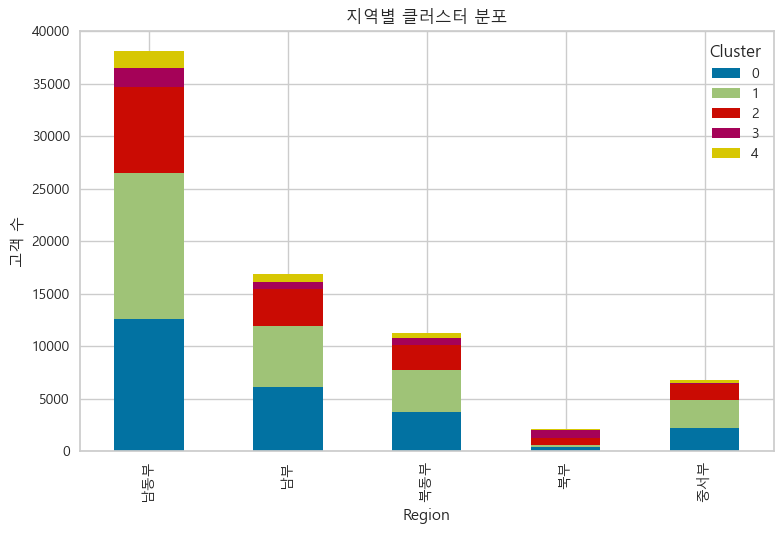

In [391]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 나눔 폰트 설치 후 경로 지정 (Colab 환경에선 설치 필요함)
font_path = 'C:/Windows/Fonts/malgun.ttf'

# 폰트 등록
fontprop = fm.FontProperties(fname=font_path, size=12)
mpl.rc('font', family=fontprop.get_name())
plt.rcParams['axes.unicode_minus'] = False

# 시각화: 지역별 클러스터 분포
plt.figure(figsize=(10, 6))
cluster_dist.plot(kind='bar', stacked=True)
plt.title('지역별 클러스터 분포')
plt.xlabel('Region')
plt.ylabel('고객 수')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()